# Imports

In [1]:
# Utilities
import numpy as np
import pandas as pd
import cv2
import spatial_transformer as spn

# Tensorflow
import tensorflow as tf

# Visualization
import matplotlib.pyplot as plt
plt.style.use("seaborn")

# IPython
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# Functions

### Helper functions

In [2]:
def total_parameters():
    """
        Calculates the total number of trainable parameters in the default tensorflow graph.
    """
    
    total_params = 0
    for var in tf.trainable_variables():
        shape = var.get_shape()
        
        var_params = 1
        for dim in shape:
            var_params *= dim.value
        
        total_params += var_params
        
    return total_params

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

def _epoch_batches(X, y, batch_size):
    """
        Creates a generator for training batches
    """
    if batch_size == 1:
        yield X, y
        
    num_observations = X.shape[0]
    num_batches = int(num_observations / batch_size)
    for i in range(num_batches):
        x_batch = X[i*batch_size:(i+1)*batch_size]
        y_batch = y[i*batch_size:(i+1)*batch_size]

        yield x_batch, y_batch

def _validation_batches(X_val, y_val, batch_size):
    """
        Creates a generator for validation batches
    """
    if batch_size == 1:
        yield X_val, y_val
    
    num_observations = X_val.shape[0]
    num_batches = int(num_observations / batch_size)
    for i in range(num_batches):
        xv_batch = X_val[i*batch_size:(i+1)*batch_size]
        yv_batch = y_val[i*batch_size:(i+1)*batch_size]
        
        yield xv_batch, yv_batch
        
def precision_recall(confmat):
    """
        Calculates the precision and recall of a confusion matrix, and returns the confusion matrix
        with precision and recall
    """
    acc = np.trace(confmat)/np.sum(confmat)
    pr = [confmat[i,i]/sum(confmat[:,i]) if confmat[i,i] != 0 else 0 for i in range(confmat.shape[0])]
    rc = [confmat[i,i]/sum(confmat[i,:]) if confmat[i,i] != 0 else 0 for i in range(confmat.shape[0])]
    
    df = pd.DataFrame(confmat, columns=["acne", "rosacea"])#
    df = df.rename_axis("true labels")
    df = df.rename_axis("predictions", axis="columns")
    df.loc[-1] = [str(i)[:5] for i in pr]
    rcs = [str(i)[:5] for i in rc]
    rcs.append("")
    df["recall"] = rcs
    df.rename(index={0:"acne", 1:"rosacea", -1:"precision"}, inplace=True)#
    print("Test accuracy:", acc)
    return df

def pr_rc(confmat):
    """
        Calculates the precision and recall of a confusion matrix.
    """
    pr = [confmat[i,i]/sum(confmat[:,i]) if confmat[i,i] != 0 else 0 for i in range(confmat.shape[0])]
    rc = [confmat[i,i]/sum(confmat[i,:]) if confmat[i,i] != 0 else 0 for i in range(confmat.shape[0])]
    return np.mean(pr), np.mean(rc)

### Model related functions

#### Spatial Transformer Network and Classification Network

In [3]:
# spatial transformer network
def spatial_transformer_network(X_in, layers=[(8, [5,5], "MAX", [2,2])]*2, dense_units=50, factor=2):
    """
        Implements a spatial transformer network onto the default tensorflow graph.
        
        The `layers` parameter is an array of tuples, where each tuple corresponds to a layer in the localization network.
        The tuple elements specify number of filters, window size, pool type, and pool window size
    """
    with tf.name_scope("localization_network"):
        # first hidden layer
        loc_pool1 = tf.nn.pool(X_in, pooling_type=layers[0][2], window_shape=layers[0][3], padding="SAME")
        loc_conv1 = tf.layers.conv2d(loc_pool1, filters=layers[0][0], kernel_size=layers[0][1], strides=[1, 1], padding="SAME")
        spn_layer_outs = [loc_conv1]
        
        # consecutive hidden layers
        for layer in layers[1:]:
            loc_pooli = tf.nn.pool(spn_layer_outs[-1], pooling_type=layer[2], window_shape=layer[3], padding="SAME")
            loc_convi = tf.layers.conv2d(loc_pooli, filters=layer[0], kernel_size=layer[1], strides=[1, 1], padding="SAME")
            spn_layer_outs.append(loc_convi)
        
        # output layer
        loc_flatten = tf.contrib.layers.flatten(inputs=spn_layer_outs[-1])
        loc_dense1 = tf.layers.dense(loc_flatten, units=dense_units, activation=tf.nn.relu)

        # output (theta)
        W_theta = tf.get_variable(shape=[50, 6], initializer=tf.constant_initializer(0.0), name="W_theta")
        b_theta = tf.Variable(tf.constant([1, 0, 0, 0, 1, 0], dtype=tf.float32), name="b_theta")
        theta = tf.matmul(loc_dense1, W_theta) + b_theta

    # grid generator
    with tf.name_scope("grid_generator"):
        V_dim = D[0]//factor
        V = spn.transformer_layer(U=X_in, theta=theta, out_size=(V_dim, V_dim))
        V.set_shape([None, V_dim, V_dim, C])
        V_val = tf.transpose(V, [0, 2, 3, 1])
        
    return V, V_val

# classification network
def classification_network(X_in, layers=[(16, [3,3], "MAX", [2,2])]*2, dense_units=256):
    """
        Implements a convolutional classification network onto the default tensorflow graph.
        
        The `layers` parameter is an array of tuples, where each tuple corresponds to a layer in the network.
        The tuple elements specify number of filters, window size, pool type, and pool window size
    """
    
    with tf.name_scope("classifier"):
        # first hidden layer
        clf_conv1 = tf.layers.conv2d(X_in, filters=layers[0][0], kernel_size=layers[0][1], padding="SAME")
        clf_pool1 = tf.nn.pool(clf_conv1, pooling_type=layers[0][2], window_shape=layers[0][3], padding="SAME")
        clf_layer_outs = [clf_pool1]
        
        # consecutive hidden layers
        for layer in layers[1:]:
            clf_convi = tf.layers.conv2d(clf_layer_outs[-1], filters=layer[0], kernel_size=layer[1], padding="SAME")
            clf_pooli = tf.nn.pool(clf_convi, pooling_type=layer[2], window_shape=layer[3], padding="SAME")
            clf_layer_outs.append(clf_pooli)
            
        # output layer
        clf_flatten = tf.contrib.layers.flatten(inputs=clf_layer_outs[-1])
        clf_dense1 = tf.layers.dense(clf_flatten, units=dense_units, activation=tf.nn.relu)
        #clf_out = tf.layers.dense(clf_dense1, units=K, activation=tf.nn.softmax)
        clf_out = tf.layers.dense(clf_dense1, units=K)
        
    return clf_out

#### Training loop

In [4]:
def train_model(n_epochs, train_batch_size, val_batch_size, spn=False, writer_path="tb_logdir/default"):
    """
        Function for training the model.
    """

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Tensorboard summary writers
        train_writer = tf.summary.FileWriter(writer_path + "/training", graph=sess.graph)
        validation_writer = tf.summary.FileWriter(writer_path + "/validation")

        # Evaluation data structures to hold mean performance for each epoch.
        epoch_mean_train_costs, epoch_mean_train_errors = [], []
        epoch_mean_val_errors = []
        spn_imgs = []

        for epoch in range(n_epochs):

            # Evalutation data structures to hold performance for each batch
            batch_train_costs, batch_train_errors = [], []
            batch_val_errors = []

            # training
            for x_batch, y_batch in _epoch_batches(X_train, y_train, train_batch_size):

                # run training operation and collect cost and error
                train_feed_dict = {x_pl:x_batch, y_pl:y_batch}
                train_fetches = [train_op, summary_merged, cost, error]
                _, tr_summ, train_cost, train_error = sess.run(train_fetches, train_feed_dict)

                batch_train_costs.append(train_cost)
                batch_train_errors.append(train_error)

            epoch_mean_train_costs.append(np.mean(batch_train_costs))
            epoch_mean_train_errors.append(np.mean(batch_train_errors))
            train_writer.add_summary(tr_summ, epoch)

            # validation
            confusion_matrix = [[0]*K]*K
            if spn:
                for xv_batch, yv_batch in _validation_batches(X_val, y_val, val_batch_size):

                    # collect validation error and spn image
                    val_feed_dict = {x_pl:xv_batch, y_pl:yv_batch}
                    val_fetches = [error, V_val, confmat, summary_merged]
                    val_error, trans_img, batch_confmat, err_summ = sess.run(val_fetches, val_feed_dict)

                    batch_val_errors.append(val_error)
                    spn_imgs.append(trans_img)
                    confusion_matrix = np.add(confusion_matrix, batch_confmat)

                epoch_mean_val_errors.append(np.mean(batch_val_errors))
                spn_eval = np.concatenate(spn_imgs, axis=0)
                pr, rc = pr_rc(confusion_matrix)
                validation_writer.add_summary(err_summ, epoch)

            else:
                for xv_batch, yv_batch in _validation_batches(X_val, y_val, val_batch_size):

                    # collect validation error
                    val_feed_dict = {x_pl:xv_batch, y_pl:yv_batch}
                    val_fetches = [error, confmat, summary_merged]
                    val_error, batch_confmat, err_summ = sess.run(val_fetches, val_feed_dict)

                    batch_val_errors.append(val_error)
                    confusion_matrix = np.add(confusion_matrix, batch_confmat)

                epoch_mean_val_errors.append(np.mean(batch_val_errors))
                pr, rc = pr_rc(confusion_matrix)
                validation_writer.add_summary(err_summ, epoch)


            print("At epoch {:<3}: tr_cost {:.7f}, tr_err {:.7f} | val_err {:.7f}, val_pr {:.7f}, val_rc {:.7f}".format(epoch,
                                                                                          epoch_mean_train_costs[-1],
                                                                                          epoch_mean_train_errors[-1],
                                                                                          epoch_mean_val_errors[-1],
                                                                                          pr, rc))
        
        return epoch_mean_train_costs, epoch_mean_train_errors, epoch_mean_val_errors, confusion_matrix

# Load Data

In [5]:
data = np.load("../data/data_matrix_128_derm101.npz")
X = data["X"].astype(np.uint8)
y = data["y"].astype(np.uint8).flatten()

N = X.shape[0]
D = X.shape[1:3]
C = X.shape[3]
K = 2

print("Total number of observations:", N)
print("Image dimensions:", D)
print("Number of image color channels:", C)
print("Number of classes:", K)
print("0: Acne, 1: Rosacea")

y = one_hot(y, K)

# 90% for training 10% for validation
train_idx = int(X.shape[0]*0.9)

X_train = X[:train_idx]
y_train = y[:train_idx]
X_val = X[train_idx:]
y_val = y[train_idx:]

print("Number of acne patients in training set:", len(y_train[y_train==[1,0]]))
print("Number of rosacea patients in training set:", len(y_train[y_train==[0,1]]))

print("Number of acne patients in validation set:", len(y_val[y_val==[1,0]]))
print("Number of rosacea patients in validation set:", len(y_val[y_val==[0,1]]))

Total number of observations: 2308
Image dimensions: (128, 128)
Number of image color channels: 3
Number of classes: 2
0: Acne, 1: Rosacea
Number of acne patients in training set: 1166
Number of rosacea patients in training set: 2988
Number of acne patients in validation set: 146
Number of rosacea patients in validation set: 316


# Build Model

In [6]:
# input placeholders
x_pl = tf.placeholder(shape=[None, D[0], D[1], C], dtype=tf.float32, name="X")
y_pl = tf.placeholder(shape=[None, K], dtype=tf.float32, name="y")

"""
Spatial Transformer Network
    Comment out below code to include the spatial transformer
"""
#V, V_val = spatial_transformer_network(x_pl,
#                                       layers=[(8, [5,5], "MAX", [2,2])]*2,
#                                       dense_units=50,
#                                       factor=3)


"""
Classificaiton network
   Input V instead of x_pl if using spation transformer 
"""
clf_out = classification_network(x_pl,
                                 layers=[(16, [5,5], "MAX", [2,2]),
                                        (8, [3,3], "MAX", [2,2]),
                                        (4, [3,3], "MAX", [2,2])],
                                 dense_units=512)

# cost function
with tf.name_scope("cost_function"):
    cost = tf.losses.sigmoid_cross_entropy(logits=clf_out, multi_class_labels=y_pl)
    
# optimizer
with tf.name_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(0.0001)
    train_op = optimizer.minimize(cost)
    
# performance
with tf.name_scope("performance"):
    prediction = tf.argmax(clf_out, axis=1)
    labels = tf.argmax(y_pl, axis=1)
    
    confmat = tf.confusion_matrix(predictions=prediction, labels=labels, num_classes=K)
    
    correct_preds = tf.equal(labels, prediction)
    accuracy = tf.reduce_mean(tf.cast(correct_preds, dtype=tf.float32))
    error = 1 - accuracy
    
print("Total parameters:", total_parameters())

Total parameters: 33558638


In [7]:
# tensorboard summaries (training statistics)
cost_summary = tf.summary.scalar("Cost", cost)
error_summary = tf.summary.scalar("Error", error)
summary_merged = tf.summary.merge_all()

# Train Model
OBS. Set `spn=True` if using spatial transformer.

At epoch 0  : tr_cost 167.2343292, tr_err 0.3180488 | val_err 0.3086956, val_pr 0.6400690, val_rc 0.6346305
At epoch 1  : tr_cost 8.2309771, tr_err 0.2785366 | val_err 0.2869565, val_pr 0.6735289, val_rc 0.5882558
At epoch 2  : tr_cost 6.8633847, tr_err 0.2546342 | val_err 0.4521739, val_pr 0.6321438, val_rc 0.6321438
At epoch 3  : tr_cost 5.4071665, tr_err 0.2307317 | val_err 0.3043478, val_pr 0.6588235, val_rc 0.6707966
At epoch 4  : tr_cost 3.6382513, tr_err 0.1843902 | val_err 0.3086956, val_pr 0.6570903, val_rc 0.6712765
At epoch 5  : tr_cost 1.5699778, tr_err 0.1312195 | val_err 0.2956522, val_pr 0.6699622, val_rc 0.6844952
At epoch 6  : tr_cost 0.9124762, tr_err 0.1043902 | val_err 0.2956522, val_pr 0.6602151, val_rc 0.6625076
At epoch 7  : tr_cost 1.0989485, tr_err 0.1248781 | val_err 0.3043478, val_pr 0.6503226, val_rc 0.6524736
At epoch 8  : tr_cost 2.1536667, tr_err 0.1517073 | val_err 0.3043478, val_pr 0.6518971, val_rc 0.6561382
At epoch 9  : tr_cost 3.0669222, tr_err 0.17

### Performance evaluation

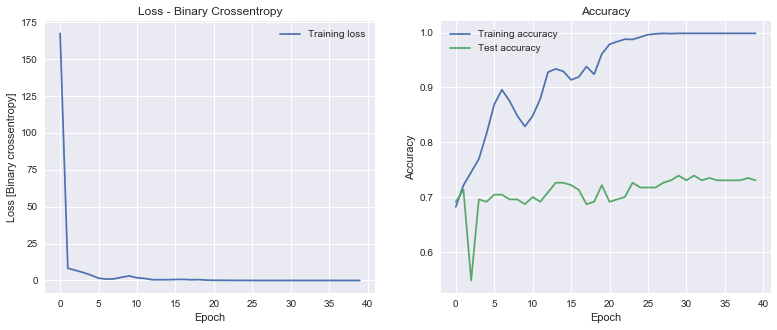

Test accuracy: 0.730434782609


predictions,acne,rosacea,recall
true labels,,,
acne,33,40,0.452
rosacea,22,135,0.859
precision,0.6,0.771,


In [8]:
tr_cost, tr_err, val_err, confusion_matrix = train_model(n_epochs=40, train_batch_size=50,
                                                         val_batch_size=10, spn=False,
                                                         writer_path="tb_logs/baseline_nospn3")

printmd("### Performance evaluation")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
ax1.plot(tr_cost, label="Training loss")
ax1.set_title("Loss - Binary Crossentropy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss [Binary crossentropy]")
ax2.plot(np.subtract(1,tr_err), label="Training accuracy")
ax2.plot(np.subtract(1,val_err), label="Test accuracy")
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax1.legend()
ax2.legend()
plt.show()

precision_recall(confusion_matrix)